In [86]:

import numpy as np
import numpy.linalg as la
import pandas as pd
from scipy import spatial
import matplotlib.pyplot as plt
from math import *
import time


## Problem Formulation

$$
\phi(x) = a_0x_0+a_1x_1+a_2x_2+ (1+a_3)x_0^2/2+(1+a_4)x_1^2/2 + (1+a_5)x_2^2/2 + a_6x_0x_1+a_7x_1x_2+a_8x_2x_0 \\
$$
$$
T(x) =  \begin{pmatrix} a_0 + (1+a_3) x_0 + a_6 x_1 + a_8x_2 \\ 
a_1 + (1+a_4) x_1 + a_6 x_0 + a_7x_2\\
a_2 + (1+a_5)x_2 + a_7x_1 + a_8x_0\end{pmatrix}\\
$$ 
$$
g(z) =b_0 + b_1 z_0 + b_2 z_1 +b_3z_2+ 0.5 b_4 z_0^2 + 0.5b_5z_1^2+0.5b_6z_2^2+b_7 z_0z_1 + b_8z_1z_2+b_9z_2z_0
$$
$$
	\min_\phi \max_g L(\phi, g) \equiv	 \sum _i^N n_ig(\nabla \phi(x_i)) -\sum_j^M m_i e^{g(y_j)}  
$$
$$
L(x,y,a,b) =	  \sum _i^N n_ig(T(x_i)) -\sum_j^M m_i e^{g(y_j)} 
$$
$$
{\partial}_{a_k}L = \sum _i^N n_i   \nabla_z g(T(x_i)).{\partial}_{a_k}T(x_i) 
$$
$$
{\partial}_{b_k}L = \sum _i^N n_i   {\partial}_{b_k} g(T(x_i))- \sum_j^M m_i {\partial}_{b_k}g(y_j)e^{g(y_j)}  
$$



In [87]:
## Set up test datas
d = 3
Nx = 200
Ny = 100

# #Guassians
# mx = np.array([0,0])
# sx = np.array([[1.0,0.0],[0.0,1.0]])
# my = np.array([5,5])
# sy = np.array([[9.0,0.0],[0.0,9.0]])
# x = np.random.multivariate_normal(mx,sx,Nx)
# y = np.random.multivariate_normal(my,sy,Ny)

#Gaussian to another Gaussian
mx = np.array([0,0,0])
sx = np.array([[4.0,0.0,0.0],[0.0,4.0,0.0],[0.0,0.0,4.0]])
my1 = np.array([4,0,0])
sy1 = np.array([[2.0,0.0,0.0],[0.0,2.0,0.0],[0.0,0.0,2.0]])
my2 = np.array([-4,0,0])
sy2 = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]])
x = np.random.multivariate_normal(mx,sx,Nx)
y1 = np.random.multivariate_normal(my1,sy1,Ny)
y = np.concatenate([y1],axis=0)



Text(0.5, 0.778688, 'Tx')

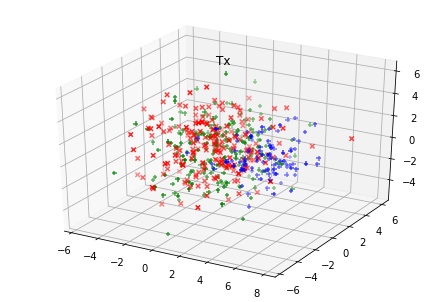

In [88]:
from mpl_toolkits.mplot3d import Axes3D
fig1 = plt.figure(2)
ax = Axes3D(fig1)
ax.scatter(x[:,0],x[:,1],x[:,2], color = 'red', marker = 'x');
plt.title('x')


ax.scatter(y[:,0],y[:,1],y[:,2], color = 'blue', marker = '+');
plt.title('y')

ax.scatter(Tx[:,0],Tx[:,1],Tx[:,2], color = 'green', marker = '+');
plt.title('Tx')


In [89]:
## Functions definition
def T (a,x): ## T(a,x) = gradx phi(a,x)
    T_1 = a[0]+(1+a[3])*x[0] +a[6]*x[1]+a[8]*x[2]
    T_2 = a[1]+(1+a[4])*x[1] +a[6]*x[0]+a[7]*x[2]
    T_3 = a[2]+(1+a[5])*x[2] +a[7]*x[1]+a[8]*x[0]
    return np.array([T_1,T_2,T_3])
def dg (b,z): ## gradz g(b,z)
    dg_1 = b[1]+b[4]*z[0]+b[7]*z[1]+b[9]*z[2]
    dg_2 = b[2]+b[5]*z[1]+b[7]*z[0]+b[8]*z[1]
    dg_3 = b[3]+b[6]*z[2]+b[8]*z[1]+b[9]*z[0]
    return np.array([dg_1,dg_2,dg_3])
def daT (x): ## grada T(a,x)
    da0T = [1,0,0]
    da1T = [0,1,0]
    da2T = [0,0,1]
    da3T = [x[0],0,0]
    da4T = [0,x[1],0]
    da5T = [0,0,x[2]]
    da6T = [x[1],x[0],0]
    da7T = [0,x[2],x[1]]
    da8T = [x[2],0,x[0]]
    return np.array([da0T,da1T,da2T,da3T,da4T,da5T,da6T,da7T,da8T])
def dbg (z): ## gradb g(b,z)
    return np.array([1,z[0],z[1],z[2],0.5*z[0]**2,0.5*z[1]**2,0.5*z[2]**2,z[0]*z[1],z[1]*z[2],z[2]*z[0] ])
def g(b,z): ## g(b,z)
    result = b[0]+b[1]*z[0]+b[2]*z[1]+b[3]*z[2]+0.5*b[4]*z[0]**2+0.5*b[5]*z[1]**2+0.5*b[6]*z[2]+b[7]*z[0]*z[1]+b[8]*z[1]*z[2]+b[9]*z[2]*z[0]
    return result
    
def G(x,y,a,b,n,m): ## gradz L
    Nx = len(x)
    Ny = len(y)
    da = len(a)
    db = len(b)
    GL = np.zeros(da+db)
    for j in range(da):
        GL[j] =  sum([n[i]*np.dot(dg(b,T(a,x[i])),daT(x[i])[j]) for i in range(Nx) ])
    for k in range(da,da+db):
        GL[k] =  sum([n[t]*dbg(T(a,x[t]))[k-da] for t in range(Nx)])- sum([m[s]*dbg(y[s])[k-da]*np.exp(g(b,y[s])) for s in range(Ny)])
        
    return GL
def L(x,y,a,b,n,m): ## L 
    Nx = len(x)
    Ny = len(y)
    return sum([n[i]*g(b,T(a,x[i])) for i in range(Nx)])- sum([m[j]*np.exp(g(b,y[j])) for j in range(Ny)])

def checkcond(aold,bold,anew,bnew): # check acceptence condition#
    cond = False
    if L(x,y,anew,bold,n,m) <= L(x,y,anew,bnew,n,m) and L(x,y,anew,bnew,n,m) <= L(x,y,aold,bnew,n,m):
        cond = True
    return cond    

In [90]:
## Initialization
Nx = len(x)
Ny = len(y)
da = 9
db = 10
n = np.ones(Nx)/Nx
m = np.ones(Ny)/Ny
##

vx = np.cov(x.T)
vy = np.cov(y.T)
mx = np.mean(x,axis=0)
my = np.mean(y,axis=0)
I = np.eye(da+db)
J = I
J[db:] = -I[db:]
## Initialization of 0 step
a0 = np.zeros(da)
b0 = np.zeros(db)
b0[0] = 0.5*(my.dot(la.solve(vy,my)) - mx.dot(la.solve(vx,mx)))
B1 = la.solve(vx,mx) - la.solve(vy,my)
b0[1] = B1[0]
b0[2] = B1[1]
b0[3] = B1[2]
B2 = 0.5*(la.inv(vy)-la.inv(vx))
b0[4] = B2[0,0]
b0[5] = B2[1,1]
b0[6] = B2[2,2]
b0[7] = 2*B2[0,1]
b0[8] = 2*B2[1,2]
b0[9] = 2*B2[0,2]
z0 = np.concatenate([a0,b0],axis=0)
B0 = J
mu0 = 2
G0 = G(x,y,a0,b0,n,m)



In [91]:
B0 = J
mu0 = 2
G0 = G(x,y,a0,b0,n,m)
eta0 = mu0/la.norm(G0,2)
z1 = z0- eta0*np.matmul(B0,G0)
a1 = z1[:da]
b1 = z1[da:]
for i in range(99):## update mu
    z1 = z0- (mu0/la.norm(G0,2))*np.matmul(B0,G0)
    a1 = z1[:da]
    b1 = z1[da:]
    if checkcond(a0,b0,a1,b1) == False:
        mu0 = mu0 / 2
    else :
        print(mu0,i) 
        break
mulist = [mu0]
G1 = G(x,y,a1,b1,n,m)
Gold = G1
Golder = G0
Bold = B0
muold = mu0

zold = z1
aold = a1
bold = b1

Niter = 100
for t in range(Niter):
    alpha = la.norm(np.matmul(J,Gold)- np.matmul(Bold,Golder),2)/(np.matmul(Golder.T,np.matmul(J,Gold)- np.matmul(Bold,Golder)))
    alphas = np.sign(alpha)*np.min([np.abs(alpha),la.norm(Bold,2)])
    alphas0 = 1
    Bnew = Bold + alphas0*np.matmul(np.matmul(J,Gold)- np.matmul(Bold,Golder),
                                   (np.matmul(J,Gold)- np.matmul(Bold,Golder)).T)/(la.norm(np.matmul(J,Gold)- np.matmul(Bold,Golder),2))**2
    munew = np.min([10*muold,np.max(mulist)]) ## free parameter 2 
    znew = zold- (munew/la.norm(Gold,2))*np.matmul(Bnew,Gold)
    anew = znew[:da]
    bnew = znew[da:]
    for i in range(99):## update mu
        znew = zold- (munew/la.norm(Gold,2))*np.matmul(Bnew,Gold)
        anew = znew[:da]
        bnew = znew[da:]
        if checkcond(aold,bold,anew,bnew) == False:
            munew = munew / 2
        else :
            print(munew/la.norm(Gold,2),i) 
            break
    mulist.append(munew)
    Tx = np.array([T(anew,i) for i in x])
    Gnew = G(x,y,anew,bnew,n,m)
    Golder = Gold
    Gold = Gnew
    Bold = Bnew
    muold = munew
    zold = znew
    aold = anew
    bold = bnew
    print("# of iteration", t)
        
        
    
    
    
anew

1.0 1
0.019161095363693034 2
# of iteration 0
2.312307184250164e-18 56
# of iteration 1
1.806489987695439e-19 7
# of iteration 2
2.258112484619299e-19 3
# of iteration 3
1.4113203028870618e-19 4
# of iteration 4
8.820751893044135e-20 4
# of iteration 5
1.1025939866305167e-19 3
# of iteration 6
6.89121241644073e-20 4
# of iteration 7
8.614015520550911e-20 3
# of iteration 8
8.614015520550911e-19 0
# of iteration 9
2.6918798501721564e-19 5
# of iteration 10
1.3459399250860778e-18 1
# of iteration 11
5.257577832367475e-20 8
# of iteration 12
8.21496536307418e-21 6
# of iteration 13
1.0268706703842724e-20 3
# of iteration 14
1.2835883379803405e-20 3
# of iteration 15
8.022427112377128e-21 4
# of iteration 16
1.0028033890471412e-20 3
# of iteration 17
6.267521181544633e-21 4
# of iteration 18
7.834401476930791e-21 3
# of iteration 19
9.793001846163488e-21 3
# of iteration 20
6.12062615385218e-21 4
# of iteration 21
7.650782692315226e-21 3
# of iteration 22
4.781739182697016e-21 4
# of itera

array([ 0.5213024 , -0.02798606,  0.07339133, -0.18831326, -0.11156288,
       -0.06327221,  0.26066297, -0.013279  ,  0.12023174])